## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [1]:
# from get_data import unpack
# unpack('facial-keypoints-data.zip')

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [2]:
### Useful routines for preparing data
import numpy as np
from numpy import array, zeros

from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import pandas as pd

from skimage.io import imshow


def load_imgs_and_keypoints(dirname='facial-keypoints'):
    frame=pd.read_csv('data/gt.csv')
#     frame = frame[:30]
    mat = frame.values[:,frame.columns != 'filename']
    imgs   = []
    points = []

    S=100
    for index, row in frame.iterrows():
        raw=imread('data/images/%s'%row.filename);
        vec = mat[index,:]
        vec[::2]  /= raw.shape[0]
        vec[1::2] /= raw.shape[1]
        vec -= 0.5

        res=resize(raw,(S,S));
        if len(res.shape)==2:
            res=gray2rgb(res);
        imgs.append(np.array(res))
        points.append(vec.astype(np.double))
    return imgs, points
imgs, points = load_imgs_and_keypoints()
print("Loaded %d images"%len(imgs))

C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Loaded 6000 images


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


array([-0.30534351, -0.30534351, -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480916, -0.30152672, -0.24045802, -0.20610687,
       -0.17557252, -0.21374046, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267176, -0.19847328,  0.23664122, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412214,  0.03435115,
        0.1870229 ,  0.14122137,  0.18320611])

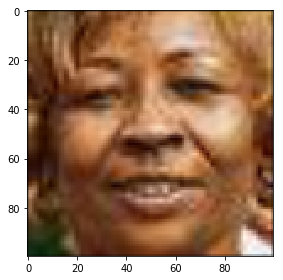

In [3]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[-1])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

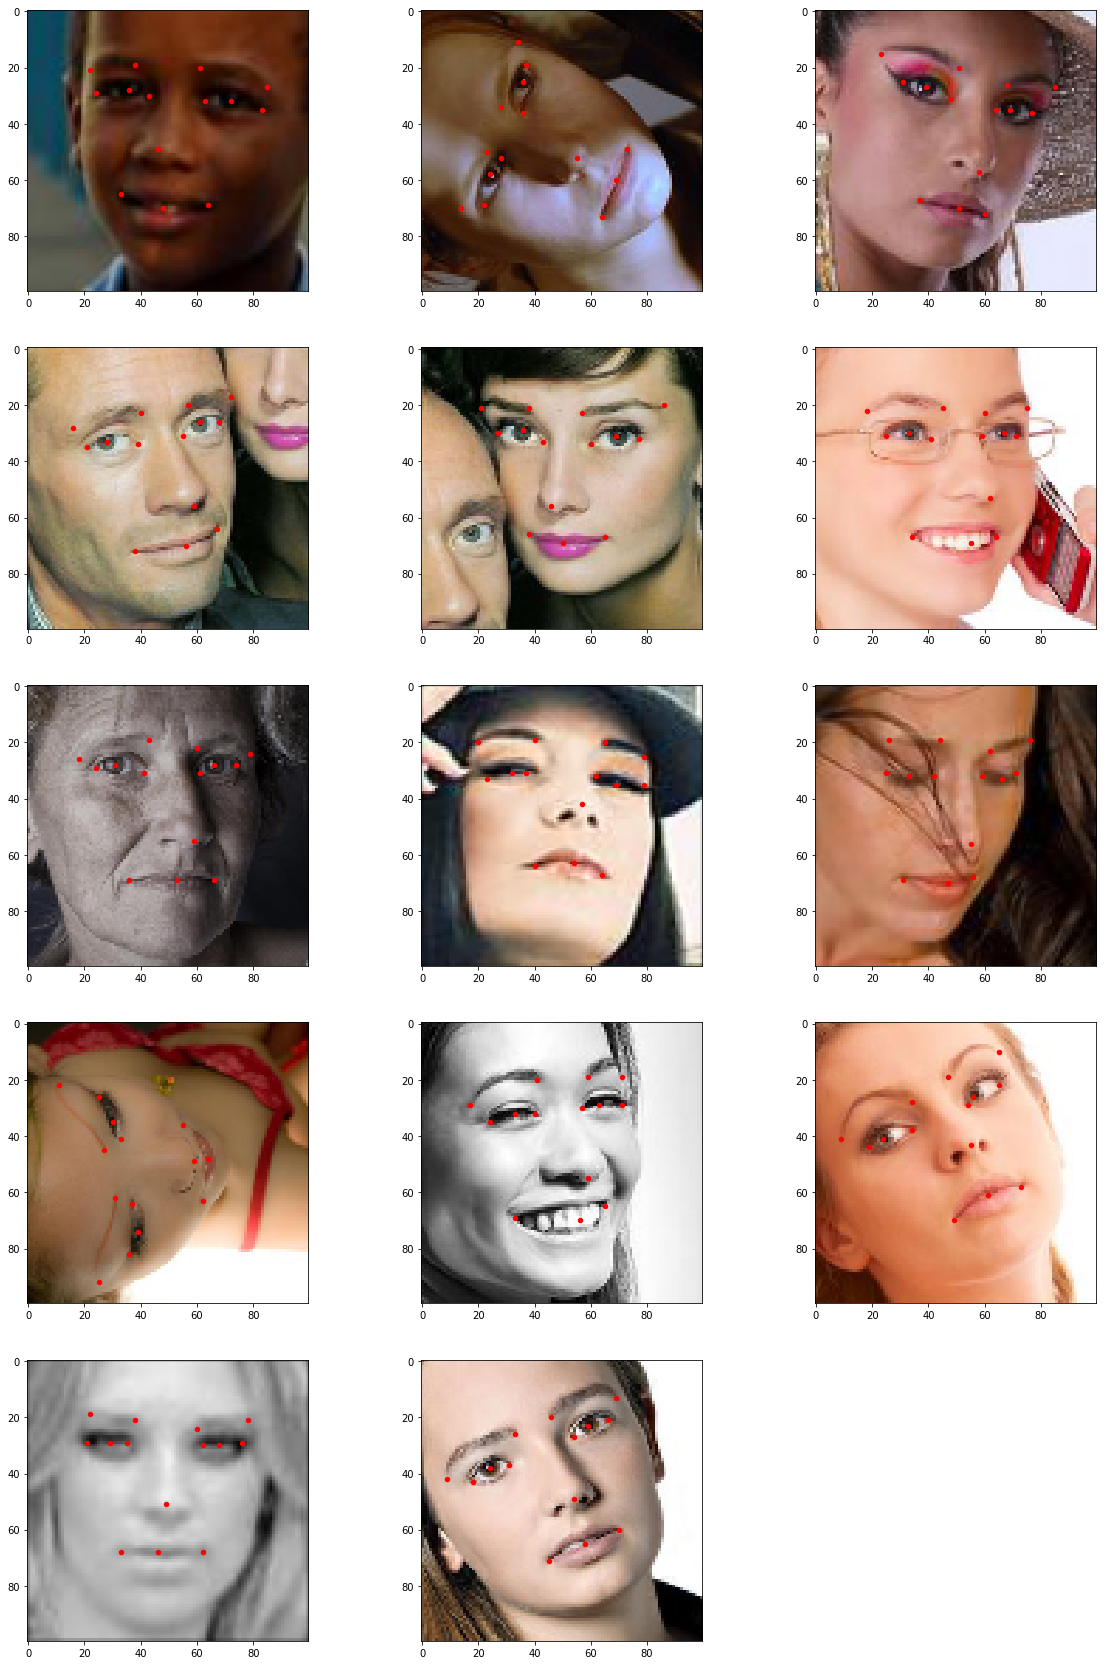

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint as randi
from random import randrange


# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle
def get_point_xy(img,points):
    x=np.round( (img.shape[0]*(points[::2]+0.5)) )
    y=np.round( (img.shape[1]*(points[1::2]+0.5)) )
    return x,y


def visualize_points(imgs, points, ref_points = None):
    plt.figure(figsize=(20, 30))
    for i,img in enumerate(imgs):
        plt_idx = i+1
        plt.subplot(5, 3, plt_idx)    
        x,y = get_point_xy(img,points[i])
        plt.scatter(x,y, s=20, facecolors='r', edgecolors='r');
        if not( ref_points is None):
            x,y = get_point_xy(img,ref_points[i])
            plt.scatter(x,y, s=20, facecolors='g', edgecolors='g');
        plt.imshow(img)
    if not( ref_points is None):
        print('Red - model response, Green - true answers')
    plt.show()

R=slice(1,15,1)
visualize_points(imgs[R], points[R])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [5]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

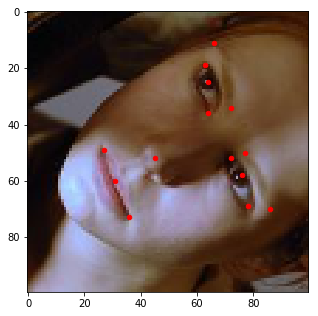

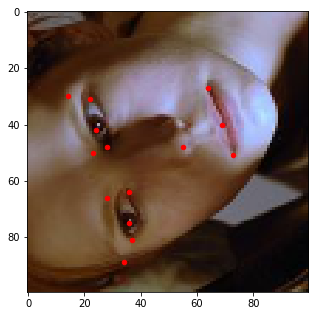

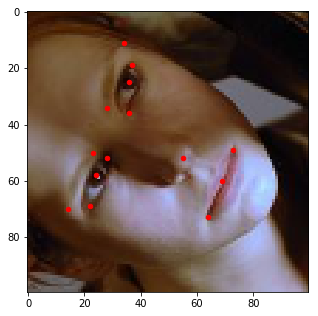

In [31]:
def flip_img_hor(img, points):
    img_flip = img[:, ::-1]
    pnt_flip = np.copy(points);
    pnt_flip[::2]*=-1
    return img_flip, pnt_flip

def flip_img_ver(img, points):
    img_flip = img[::-1,: ]
    pnt_flip = np.copy(points);
    pnt_flip[1::2]*=-1
    return img_flip, pnt_flip

fh_img, fh_points = flip_img_hor(imgs[2], points[2])
fv_img, fv_points = flip_img_ver(imgs[2], points[2])


visualize_points([fh_img], [fh_points])
visualize_points([fv_img], [fv_points])
visualize_points([imgs[2]], [points[2]])
# visualize_points(imgs[1], points[1])

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [32]:
# Write your code here
aug_imgs_train=[]
aug_points_train=[]
for I,P in zip(imgs_train,points_train):
    img_flip, ptr_flip=flip_img_hor(I,P)
    aug_imgs_train.append(img_flip)
    aug_points_train.append(ptr_flip)

    img_flip, ptr_flip=flip_img_ver(I,P)
    aug_imgs_train.append(img_flip)
    aug_points_train.append(ptr_flip)

X_train = np.array(imgs_train + aug_imgs_train)
y_train = np.array(points_train + aug_points_train)
X_test  = np.array(imgs_val)
y_test  = np.array(points_val)


X_train[1].shape


(100, 100, 3)

In [38]:
K=np.random.randint(len(X_train))
visualize_points([X_train[K]], [y_train[K]])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [46]:
from keras.models import Sequential
import keras.layers as L
import keras.regularizers as R
from keras.layers import Conv2D, MaxPooling2D, Flatten,Dense,Dropout

from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping , ModelCheckpoint

def print_history(history):
    plt.plot(np.log(history.history['loss']))
    plt.plot(np.log(history.history['val_loss']))
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def get_dnn_model():
#     inp_shape=imgs_train[0].shape
#     model = Sequential()
#     model.add(L.InputLayer( (100, 100, 3) ))
#     nchannels = [64,64,64];

#     for N in nchannels:
#         model.add(L.Conv2D( N, (3,3), padding='same', kernel_regularizer = R.l2(0.0)))
#         model.add(L.Activation('relu'))
#         model.add(L.MaxPooling2D(pool_size=(2, 2)))

#     model.add(L.Flatten())
#     L2_reg=0.000001
#     model.add(L.Dense( 600, activation="relu",kernel_regularizer = R.l2(L2_reg)))
#     model.add(L.Dropout(0.5))
#     model.add(L.Dense( 600, activation="relu",kernel_regularizer = R.l2(L2_reg)))
#     model.add(L.Dropout(0.5))
    
#     model.add(L.Dense( len(points_train[0])))
    
# #     sgd  = SGD( lr=0.01 , momentum=0.9 , nesterov=True)
#     adam = Adam(lr=0.001/2)
#     model.compile(loss='mean_squared_error', optimizer=adam)
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu',input_shape=(100,100,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='selu'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='selu'))
    model.add(Dropout(0.2))
    model.add(Dense(28))
    model.compile(loss='mean_squared_error',   optimizer=Adam(lr=0.005))
    
    return model
model=get_dnn_model()

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [47]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info

callbacks = [EarlyStopping(monitor='val_loss', patience=7),
             ModelCheckpoint(filepath='best_model_dnn.h5', monitor='val_loss', save_best_only=True)]

model=get_dnn_model()
history = model.fit(X_train, y_train, shuffle=True,epochs=50, batch_size=300, verbose=1, validation_split=0.1,callbacks=callbacks)
print_history(history)

Train on 14580 samples, validate on 1620 samples
Epoch 1/50
14580/14580 [==============================] - 7s 449us/step - loss: 0.1544 - val_loss: 0.0448
Epoch 2/50
14580/14580 [==============================] - 5s 358us/step - loss: 0.0362 - val_loss: 0.0435
Epoch 3/50
14580/14580 [==============================] - 5s 357us/step - loss: 0.0298 - val_loss: 0.0233
Epoch 4/50
14580/14580 [==============================] - 5s 357us/step - loss: 0.0216 - val_loss: 0.0170
Epoch 5/50
14580/14580 [==============================] - 5s 358us/step - loss: 0.0195 - val_loss: 0.0177
Epoch 6/50
14580/14580 [==============================] - 5s 358us/step - loss: 0.0189 - val_loss: 0.0155
Epoch 7/50
14580/14580 [==============================] - 5s 357us/step - loss: 0.0182 - val_loss: 0.0153
Epoch 8/50
14580/14580 [==============================] - 5s 357us/step - loss: 0.0177 - val_loss: 0.0165
Epoch 9/50
14580/14580 [==============================] - 5s 357us/step - loss: 0.0174 - val_loss: 0.01

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

## Result of train

In [48]:
y_pred_val = model.predict(X_train[1:100]);
R=slice(40,55,1)
visualize_points(X_train[R], y_pred_val[R], y_train[R])

Red - model response, Green - true answers


So generally, model learned something interesting. 

But it may be just overfitting, so let's try on the test data, which model never seen before

## Result on test

In [42]:
# Example of output
y_pred_val = model.predict(X_test);
R=slice(200,215,1)
visualize_points(X_test[R], y_pred_val[R], y_test[R])



Red - model response, Green - true answers


Looks really nice!